# Loading and Preprocessing Data with TensorFlow

# Setup

In [1]:
import sklearn
import tensorflow as tf

# The df.data API

整個 tf.data API 圍繞 tf.data.Dataset 的概念：這表示a sequence of data items。 通常，將使用從磁盤逐漸讀取數據的數據集，但為了簡單起見，這邊使用 tf.data.Dataset.from_tensor_slices() 從簡單的數據張量創建數據集：

In [2]:
X = tf.range(10)  # any data tensor
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

from_tensor_slices() 函數接受一個張量並創建一個 tf.data.Dataset，其元素是 X 沿第一維的所有切片，因此該數據集包含 10 個項目：張量 0、1、2、…、9。如果使用 tf.data.Dataset.range(10)將獲得相同的數據集（除了元素是 64 位整數而不是 32 位整數）。

可以簡單地迭代查看數據集的項目，如下所示：

In [3]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


tf.data API 是一個streaming API：可以非常有效地迭代數據集的項目，但該 API 並不是為索引或切片而設計的。

數據集還可能包含tuples of tensors，或dictionaries of name/tensor pairs，甚至 nested tuples and dictionaries of tensors。 當對 tuple, a dictionary, or a nested structure進行切片時，數據集將僅對其包含的張量進行切片，同時保留tuple/dictionary結構。 例如：

In [4]:
X_nested = {"a": ([1, 2, 3], [4, 5, 6]), "b": [7, 8, 9]}
X_nested


{'a': ([1, 2, 3], [4, 5, 6]), 'b': [7, 8, 9]}

In [5]:
dataset = tf.data.Dataset.from_tensor_slices(X_nested)
for item in dataset:
    print(item)

{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=4>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=7>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=5>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=8>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=6>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=9>}


## Chaining Transformations

擁有數據集後，可以通過調用其轉換方法對其應用各種轉換。 每個方法都會返回一個新的數據集，因此可以像這樣鏈接轉換:

In [6]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))#tf.range()從簡單的數據張量創建數據集，該數據集包含 10 個項目：張量 0、1、2、…、9
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


在這個例子中，首先在原始數據集上調用repeat()方法，它返回一個新的數據集，該數據集重複原始數據集的items三次(當然這不會將內存中的所有數據複製三遍)。
然後在這個新數據集上調用batch()方法，這又創建了一個新數據集。 這將把前一個數據集的項目分成七個項目的批次。

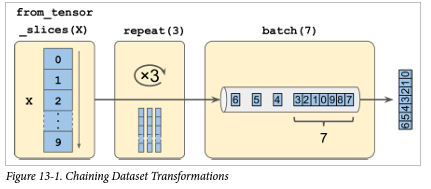

最後一個批次，batch()方法輸出大小為2的批次(而不是7)，但如果希望它刪除此最終批次，則可以使用 drop_remainder=True 調用 batch()，以便所有批次具有完全相同的大小。

還可以通過調用map()方法來轉換項目。 例如，將其中所有批次值乘以 2：

In [7]:
dataset = dataset.map(lambda x: x * 2)  # x is a batch
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


**將調用此 map() 方法來對數據應用任何預處理。** 有時，這將包括非常密集的計算，例如重塑或旋轉圖像，因此通常需要生成多個線程來加快速度。 這可以通過將 num_parallel_calls 參數設置為要運行的線程數或 tf.data.AUTOTUNE 來完成。 請注意，傳遞給 map() 方法的函數必須可轉換為TF function。

也可以使用 filter() 方法簡單地過濾數據集。 例如，此代碼創建一個僅包含總和大於 50 的批次的數據集：

In [8]:
dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 50)
for item in dataset:
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)


通常只想查看數據集中的幾個項目。 可以使用 take() 方法來實現：

In [9]:
for item in dataset.take(2):
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)


## Shuffling the Data

當訓練集中的實例獨立同分佈 (IID) 時，梯度下降效果最佳。 確保這一點的一個簡單方法是使用 shuffle() 方法對實例進行洗牌。 它將創建一個新的數據集，該數據集首先用源數據集的第一項填充緩衝區(buffer)。 然後，每當請求一項時，它都會從緩衝區中隨機取出一項，並將其替換為源數據集中的新項，直到完全迭代完源數據集。 此時它將繼續從緩衝區中隨機拉出項目，直到緩衝區為空。 必須指定緩衝區大小，重要的是要使其足夠大，否則洗牌不會非常有效，但是不要超過擁有的 RAM 量，即使有足夠的 RAM，也無需超出數據集的大小。 如果希望每次運行程序時都有相同的隨機順序，則可以提供隨機種子。 例如，以下代碼創建並顯示一個包含整數 0 到 9 的數據集，重複兩次，使用大小為 4 的緩衝區和 42 的隨機種子進行混洗，並使用批量大小 7 進行批處理：

In [10]:
dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([1 4 2 3 5 0 6], shape=(7,), dtype=int64)
tf.Tensor([9 8 2 0 3 1 4], shape=(7,), dtype=int64)
tf.Tensor([5 7 9 6 7 8], shape=(6,), dtype=int64)


如果在打亂的數據集上調用repeat()，默認情況下它將在每次迭代時生成新的順序。 這通常是一個好主意，但如果希望在每次迭代中重用相同的順序（例如，用於test或debug），則可以在調用 shuffle() 時設置 reshuffle_each_​itera⁠tion=False 。

## Interleaving Lines from Multiple Files

對於無法放入內存的大型數據集，上面這種簡單的洗牌緩衝區方法可能不夠，因為緩衝區與數據集相比會很小。 一種解決方案是對源數據本身進行混洗（例如，在 Linux 上，可以使用 shuf 命令對文本文件進行混洗）。 這肯定會大大改善洗牌！ 即使源數據被打亂，通常也希望對其進行更多打亂，否則在每個時期都會重複相同的順序，並且模型最終可能會出現偏差（出自源數據的順序）。 為了進一步打亂實例，一種常見的方法是將源數據拆分為多個文件，然後在訓練期間以隨機順序讀取它們。 但是，位於同一文件中的實例最終仍將彼此靠近。 為了避免這種情況，可以隨機選擇多個文件並同時讀取它們，交錯記錄。 然後，可以使用 shuffle() 方法添加洗牌緩衝區。 如果這聽起來工作量很大，請不要擔心，tf.data API 只需幾行代碼即可使這一切成為可能。

首先，假設已經加載了加州住房數據集，對其進行了shuffle，並將其分為訓練集、驗證集和測試集。 然後，將每個集合拆分為許多 CSV 文件，每個文件如下所示（每row包含八個輸入特徵加上目標房屋中位值）：

In [11]:
#  splits the California housing dataset

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [12]:
# split the dataset into 20 parts and save it to CSV files
import numpy as np
from pathlib import Path

def save_to_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = Path() / "datasets" / "housing"
    housing_dir.mkdir(parents=True, exist_ok=True)
    filename_format = "my_{}_{:02d}.csv"

    filepaths = []
    m = len(data)
    chunks = np.array_split(np.arange(m), n_parts)
    for file_idx, row_indices in enumerate(chunks):
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        filepaths.append(str(part_csv))
        with open(part_csv, "w") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]#target(Y)
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)

看一下這些 CSV 文件之一的前幾行：

In [13]:
print("".join(open(train_filepaths[0]).readlines()[:4]))

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621



train_filepaths 包含訓練文件路徑列表（還有 valid_filepaths 和 test_filepaths）：

In [14]:
train_filepaths

['datasets\\housing\\my_train_00.csv',
 'datasets\\housing\\my_train_01.csv',
 'datasets\\housing\\my_train_02.csv',
 'datasets\\housing\\my_train_03.csv',
 'datasets\\housing\\my_train_04.csv',
 'datasets\\housing\\my_train_05.csv',
 'datasets\\housing\\my_train_06.csv',
 'datasets\\housing\\my_train_07.csv',
 'datasets\\housing\\my_train_08.csv',
 'datasets\\housing\\my_train_09.csv',
 'datasets\\housing\\my_train_10.csv',
 'datasets\\housing\\my_train_11.csv',
 'datasets\\housing\\my_train_12.csv',
 'datasets\\housing\\my_train_13.csv',
 'datasets\\housing\\my_train_14.csv',
 'datasets\\housing\\my_train_15.csv',
 'datasets\\housing\\my_train_16.csv',
 'datasets\\housing\\my_train_17.csv',
 'datasets\\housing\\my_train_18.csv',
 'datasets\\housing\\my_train_19.csv']

#### Building an Input Pipeline

可以使用文件模式； 例如，train_filepaths =“datasets/housing/my_train_*.csv”。 現在創建一個僅包含這些文件路徑的數據集：

In [15]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

默認情況下，list_files() 函數返回一個打亂文件路徑的數據集。 一般來說，這是一件好事，但如果出於某種原因不想這樣做，可以設置 shuffle=False 。

In [16]:
# shows that the file paths are shuffled
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets\\housing\\my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_17.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_13.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_15.csv', sh

接下來，可以調用 interleave() 方法一次讀取五個文件並交錯它們的row。 還可以使用skip()方法跳過每個文件的第一行（即標題行）：

In [17]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)

interleave() 方法將創建一個數據集，該數據集將從 filepath_dataset 中提取五個文件路徑，並且對於每個文件路徑，它將調用提供的函數（本例中為 lambda）來創建一個新數據集（在本例中為 TextLineDataset）。 在此階段總共將有七個數據集：文件路徑數據集、交錯數據集以及交錯數據集內部創建的五個 TextLineDataset。 當迭代交錯數據集時，它將循環遍歷這五個 TextLineDataset，每次讀取一行，直到所有數據集都沒有項目為止。 然後，它將從 filepath_dataset 中獲取接下來的五個文件路徑，並以相同的方式交錯它們，依此類推，直到用完文件路徑。 為了使交錯發揮最佳效果，最好具有相同長度的文件； 否則文件的末尾將不會被交錯。

默認情況下，interleave() 不使用並行性； 它一次只按順序從每個文件中讀取一行。 如果希望它實際上並行讀取文件，可以將 interleave() 方法的 num_parallel_calls 參數設置為想要的線程數。 甚至可以將其設置為 tf.data.AUTOTUNE，以使 TensorFlow 根據可用 CPU 動態選擇正確的線程數。 

看看數據集現在包含什麼：

In [18]:
for line in dataset.take(5):
    print(line)

tf.Tensor(b'4.5909,16.0,5.475877192982456,1.0964912280701755,1357.0,2.9758771929824563,33.63,-117.71,2.418', shape=(), dtype=string)
tf.Tensor(b'2.4792,24.0,3.4547038327526134,1.1341463414634145,2251.0,3.921602787456446,34.18,-118.38,2.0', shape=(), dtype=string)
tf.Tensor(b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67', shape=(), dtype=string)
tf.Tensor(b'2.1856,41.0,3.7189873417721517,1.0658227848101265,803.0,2.0329113924050635,32.76,-117.12,1.205', shape=(), dtype=string)
tf.Tensor(b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215', shape=(), dtype=string)


這些是隨機選擇的五個 CSV 文件的第一rows（忽略標題行）。 看起來不錯！

## Preprocessing the Data

現在有了一個住房數據集，它將每個實例作為包含字節字符串的張量返回，需要進行一些預處理，包括解析字符串和縮放數據。 實現幾個自定義函數來執行此預處理：

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_mean, X_std = scaler.mean_, scaler.scale_  
n_inputs = 8
def parse_csv_line(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])

def preprocess(line):
    x, y = parse_csv_line(line)
    return (x - X_mean) / X_std, y

* 首先，計算了訓練集中每個特徵的平均值和標準差。 X_mean 和 X_std 只是一維張量（或 NumPy 數組），包含八個浮點數，每個輸入特徵一個。 這可以在足夠大的數據集隨機樣本上使用 Scikit-Learn StandardScaler 來完成。 後面將使用 Keras 預處理層。

* parse_csv_line() 函數獲取一行 CSV 並對其進行解析。 它使用 tf.io.decode_csv() 函數，該函數接受兩個參數：第一個是要解析的行，第二個是包含 CSV 文件中每列的默認值的數組。 該數組 (defs) 不僅告訴 TensorFlow 每列的默認值，還告訴 TensorFlow 列的數量及其類型。 在此示例中，告訴它所有特徵列都是浮點數，並且缺失值應默認為零，但提供一個 tf.float32 類型的空數組作為最後一列（目標）的默認值：該數組告訴 TensorFlow 該列包含浮點數，但沒有默認值，因此如果遇到缺失值，則會引發異常。

* tf.io.decode_csv() 函數返回一個標量張量列表（每列一個），但需要的是返回一個一維張量數組，因此對除最後一個（目標Y）之外的所有張量調用 tf.stack()：這會將這些張量堆疊到一個一維數組中。 然後，對目標值執行相同的操作：這使其成為具有單個值的一維張量數組，而不是標量張量。 tf.io.decode_csv() 函數已完成，因此它返回輸入特徵和目標。

* 最後，自定義 preprocess() 函數僅調用 parse_csv_line() 函數，通過減去特徵均值然後除以特徵標準差來縮放輸入特徵，並返回包含縮放後的特徵和目標的元組。

## Putting Everything Together

為了使代碼更可重用，將到目前為止的所有內容放在另一個輔助函數中； 它將創建並返回一個數據集，該數據集將有效地從多個 CSV 文件加載加州住房數據，對其進行預處理、洗牌和批處理

In [20]:
def csv_reader_dataset(filepaths, n_readers=5, n_read_threads=None,
                       n_parse_threads=5, shuffle_buffer_size=10_000, seed=42,
                       batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    return dataset.batch(batch_size).prefetch(1)

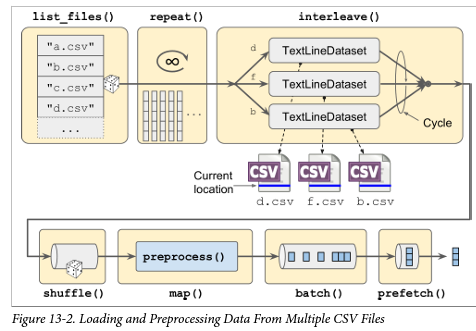

通過在自定義 csv_reader_dataset() 函數末尾調用 prefetch(1)會創建一個數據集，該數據集將盡最大努力始終領先一批。⁠換句話說，當訓練算法正在處理一批時， 數據集已經在並行工作，為下一批做好準備（例如，從磁盤讀取數據並對其進行預處理），這可以顯著提高性能。
如果還確保加載和預處理是多線程的（通過在調用 interleave()和map() 時設置 num_parallel_calls），可以利用多個 CPU 核心，並有望使準備一批數據的時間比在 GPU 上運行訓練步驟的時間短： 這樣 GPU 將幾乎 100% 得到利用（除了從 CPU 到 GPU 的數據傳輸時間），並且訓練運行速度會更快。

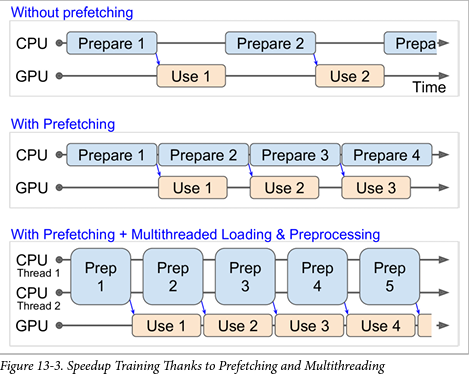

In [21]:
# extra code – show the first couple of batches produced by the dataset

example_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in example_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[-1.3957452  -0.04940685 -0.22830808  0.22648273  2.2593622   0.35200632
   0.9667386  -1.4121602 ]
 [ 2.7112627  -1.0778131   0.69413143 -0.14870553  0.51810503  0.3507294
  -0.82285154  0.80680597]
 [-0.13484643 -1.868895    0.01032507 -0.13787179 -0.12893449  0.03143518
   0.2687057   0.13212144]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.819]
 [3.674]
 [0.954]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[ 0.09031774  0.9789995   0.1327582  -0.13753782 -0.23388447  0.10211545
   0.97610843 -1.4121602 ]
 [ 0.05218809 -2.0271113   0.2940109  -0.02403445  0.16218767 -0.02844518
   1.4117942  -0.93737936]
 [-0.672276    0.02970133 -0.76922584 -0.15086786  0.4962024  -0.02741998
  -0.7853724   0.77182245]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[2.725]
 [1.205]
 [1.625]], shape=(3, 1), dtype=float32)



In [22]:
# extra code – list all methods of the tf.data.Dataset class
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● bucket_by_sequence_length()A transformation that buckets elements in a `Dataset` by length.
● cache()              Caches the elements in this dataset.
● cardinality()        Returns the cardinality of the dataset, if known.
● choose_from_datasets()Creates a dataset that deterministically chooses elements from `datasets`.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● counter()            Creates a `Dataset` that counts from `start` in steps of size `step`.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()        

## Using the Dataset with Keras

現在可以使用前面編寫的自定義 csv_reader_dataset() 函數來為訓練集、驗證集和測試集創建數據集。 訓練集將在每個epoch進行洗牌（請注意，驗證集和測試集也將被洗牌，即使並不真正需要）：

In [23]:
train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [24]:
for line in train_set.take(5):
    print(line)

(<tf.Tensor: shape=(32, 8), dtype=float32, numpy=
array([[-1.39574516e+00, -4.94068526e-02, -2.28308082e-01,
         2.26482734e-01,  2.25936222e+00,  3.52006316e-01,
         9.66738582e-01, -1.41216016e+00],
       [ 2.71126270e+00, -1.07781315e+00,  6.94131434e-01,
        -1.48705527e-01,  5.18105030e-01,  3.50729406e-01,
        -8.22851539e-01,  8.06805968e-01],
       [-1.34846434e-01, -1.86889505e+00,  1.03250686e-02,
        -1.37871787e-01, -1.28934488e-01,  3.14351842e-02,
         2.68705696e-01,  1.32121444e-01],
       [ 9.03177410e-02,  9.78999496e-01,  1.32758200e-01,
        -1.37537822e-01, -2.33884469e-01,  1.02115452e-01,
         9.76108432e-01, -1.41216016e+00],
       [ 5.21880873e-02, -2.02711129e+00,  2.94010907e-01,
        -2.40344461e-02,  1.62187666e-01, -2.84451842e-02,
         1.41179419e+00, -9.37379360e-01],
       [-6.72276020e-01,  2.97013279e-02, -7.69225836e-01,
        -1.50867864e-01,  4.96202409e-01, -2.74199769e-02,
        -7.85372376e-01,  7

現在，可以使用這些數據集構建和訓練 Keras 模型。 當調用模型的 fit() 方法時，傳遞 train_set 而不是 X_train、y_train，並傳遞 valid_data=valid_set 而不是 valid_data=(X_valid, y_valid)。 fit() 方法將負責在每個epoch重複訓練數據集一次，並在每個epoch使用不同的隨機順序：

In [25]:
# for reproducibility
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer="sgd")
model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
363/363 [==============================] - 2s 5ms/step - loss: 0.8831 - val_loss: 48.2626
Epoch 2/5
363/363 [==============================] - 1s 1ms/step - loss: 0.9369 - val_loss: 10.4785
Epoch 3/5
363/363 [==============================] - 1s 1ms/step - loss: 1.5594 - val_loss: 22.1522
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.7050 - val_loss: 4.6147
Epoch 5/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4576 - val_loss: 0.4877


在 Keras 中，compile() 方法的 steps_per_execution 參數允許定義 fit() 方法在每次調用用於訓練的 tf.function 期間將處理的批次數。 默認值為 1，因此如果將其設置為 50，通常會看到性能顯著提高。 但是，Keras 回調的 on_batch_*() 方法只會每 50 個批次調用一次。

同樣，可以將數據集傳遞給evaluate()和predict()方法：

In [27]:
test_mse = model.evaluate(test_set)
new_set = test_set.take(3)  # pretend we have 3 new samples
y_pred = model.predict(new_set)  # or you could just pass a NumPy array

3/3 [==============================] - 0s 12ms/step


(如果願意，仍然可以使用 NumPy array而不是數據集（但它們仍然需要先加載和預處理）。)

# The TFRecord Format

到目前為止一直使用 CSV 文件，它常見、簡單、方便，但效率並不高，並且不能很好地支持大型或複雜的數據結構（例如圖像或音頻），看看如何使用 TFRecords。

如果對 CSV 文件（或正在使用的任何其他格式）感到滿意，則不必使用 TFRecords。 當訓練期間遇到加載和解析數據的瓶頸，TFRecord 非常有用。

TFRecord 格式是 TensorFlow 存儲大量數據並高效讀取的首選格式。 它是一種非常簡單的二進制格式，僅包含一系列不同大小的binary records（每個binary record有一個長度、一個用於檢查長度未損壞的 CRC 校驗、實際數據、一個 CRC 校驗組成）。 可以使用 tf.io.TFRecordWriter 類輕鬆創建 TFRecord 文件：

In [28]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

And you can read it using a tf.data.TFRecordDataset:

In [29]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


默認情況下， TFRecordDataset 將逐個讀取文件，但可以通過向構造函數傳遞文件路徑列表並將 num_parallel_reads 設置為大於 1 的數字，使其並行讀取多個文件並交錯記錄。 或者，可以使用 list_files() 和 interleave() 獲得與之前讀取多個 CSV 文件相同的結果。

In [30]:
filepaths = ["my_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


## Compressed TFRecord Files

壓縮 TFRecord 文件有時很有用，特別是當它們需要通過網絡連接加載時。 可以通過設置options參數來創建壓縮的 TFRecord 文件：

In [31]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"Compress, compress, compress!")

讀取壓縮的 TFRecord 文件時，需要指定壓縮類型：

In [32]:
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                  compression_type="GZIP")

In [33]:
# extra code – shows that the data is decompressed correctly
for item in dataset:
    print(item)

tf.Tensor(b'Compress, compress, compress!', shape=(), dtype=string)

## A Brief Introduction to Protocol Buffers

儘管每個record可以使用想要的任何二進制格式，但 TFRecord 文件通常包含序列化的協議緩衝區（也稱為 protobuf）。 這是一種可移植、可擴展且高效的二進制格式。protobufs 現在被廣泛使用，特別是在 gRPC（Google 的遠程過程調用系統）中。Protocol Buffers 是由 Google 所推出的一個跨平台、語言的「可擴展的序列化資料結構」，可以把它想像成是 XML，或者是 JSON 的資料結構，但是它的資料體積更小、傳輸更快。基本上，只要定義一次，就可以在不同的語言上使用這個定義好的資料結構，例如：Python、Go、Java、C++ 等其他語言。

Protocol Buffers 的檔案容易撰寫，如同在寫文件，當你定義結構完成後，就等同於把文件寫完了。Protocol Buffers 也提供了各種編譯器讓你可以把檔案編譯成你所需要的語言格式。

使用 Protocol Buffers 在傳輸資料時，會將資料「序列化」後才送出，下圖是經過序列化後的示意圖：

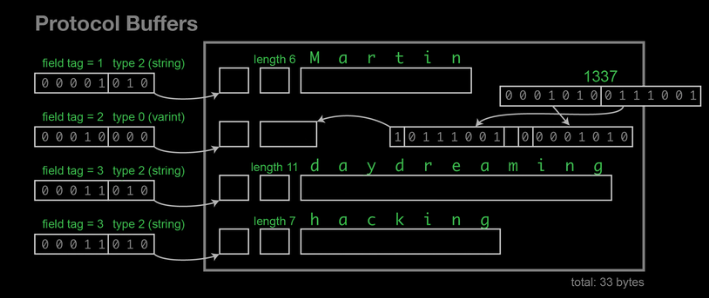

而這些被「序列化」的資料，也可以被「反序列化」回來。

Protocol Buffers 的優點除了以上所提到的，從這張圖也可以發現它提升了資料的隱匿性，一般在使用 JSON 做資料交換時，我們可以很容易地了解傳遞的內容，但是透過 Protocol Buffers 來做傳輸，因為經過編碼後，只能看到一堆字節。

## TensorFlow Protobufs

TFRecord 文件中通常使用的主要 protobuf 是Example protobuf，它代表數據集中的一個實例。 它包含一個特徵列表，其中每個特徵可以是字串列表、浮點數列表或整數列表。 

 protobuf 定義（來自 TensorFlow 的源代碼）：

In [34]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com",
                                                          b"c@d.com"]))
        }))

該代碼有點冗長且重複，但可以輕鬆地將其包裝在一個小的輔助函數中。 現在有了一個示例 protobuf，可以通過調用其 SerializeToString() 方法對其進行序列化，然後將結果數據寫入 TFRecord 文件。 寫五次來假裝有幾個聯繫人：

In [35]:
with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    for _ in range(5):
        f.write(person_example.SerializeToString())

通常將創建一個轉換腳本，該腳本從當前格式（例如 CSV 文件）中讀取，為每個實例創建一個Example protobuf，將它們序列化，並將它們保存到多個 TFRecord 文件中，最好在此過程中對它們進行打亂。 這需要做一些麻煩工作，因此再次確認這是有必要的（也許管道可以很好地處理 CSV 文件就不需要這個方法了）。


# Keras Preprocessing Layers

## The Normalization Layer

### 方法一 

直接在模型中包含預處理層

In [36]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
norm_layer = tf.keras.layers.Normalization()
model = tf.keras.models.Sequential([
    norm_layer,
    tf.keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
norm_layer.adapt(X_train)  # computes the mean and variance of every feature
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5)

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 2.4593 - val_loss: 0.9192
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.7312 - val_loss: 1.4071
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.6185 - val_loss: 1.1096
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.5951 - val_loss: 0.7824
Epoch 5/5
363/363 [==============================] - 1s 2ms/step - loss: 0.5820 - val_loss: 0.5459


### 方法二

直接在模型中包含預處理層很好且簡單，但它會減慢訓練速度（歸一化層僅非常輕微），實際上，由於預處理是在訓練期間動態執行，因此每個epoch都會發生一次。 我們可以通過在訓練前對整個訓練集進行一次歸一化即可。 為此，可以以獨立的方式使用Normalization layer（很像 Scikit-Learn StandardScaler）：

In [37]:
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_scaled = norm_layer(X_train)
X_valid_scaled = norm_layer(X_valid)

Now we can train a model on the scaled data, this time without a Normalization layer:

In [38]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1)])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
363/363 [==============================] - 1s 1ms/step - loss: 2.4682 - val_loss: 1.0982
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 0.7910 - val_loss: 1.8309
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 0.6867 - val_loss: 1.2963
Epoch 4/5
363/363 [==============================] - 0s 1ms/step - loss: 0.6510 - val_loss: 0.8726
Epoch 5/5
363/363 [==============================] - 0s 1ms/step - loss: 0.6265 - val_loss: 0.5912


這會加快訓練速度。 但現在，當將其部署到生產環境時，該模型不會對其輸入進行預處理。 為了解決這個問題，只需要創建一個新模型來包裝adapted Normalization layer和剛剛訓練的模型，就可以將這個最終模型部署到生產中，它將負責預處理其輸入並進行預測

In [39]:
final_model = tf.keras.Sequential([norm_layer, model])
X_new = X_test[:3]  # pretend we have a few new instances (unscaled)
y_pred = final_model(X_new)  # preprocesses the data and makes predictions

現在擁有了兩全其美的優點。訓練速度很快，因為在訓練開始前只對數據進行一次預處理，並且最終模型可以動態預處理其輸入，而不會出現預處理不匹配的風險。

* 與tf.data API 配合

此外，Keras 預處理層與 tf.data API 配合得很好。 例如，可以將 tf.data.Dataset 傳遞給預處理層的 Adapt() 方法。 還可以使用數據集的 map() 方法將 Keras 預處理層應用於 tf.data.Dataset。 例如，以下是如何將adapted Normalization layer應用於數據集中每個批次的輸入：

In [40]:
# extra code – creates a dataset to demo applying the norm_layer using map()
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(5)

In [41]:
dataset = dataset.map(lambda X, y: (norm_layer(X), y))

In [42]:
list(dataset.take(1))  # extra code – shows the first batch

[(<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
  array([[-0.19397898, -1.0778134 , -0.94338703,  0.01485134,  0.02073434,
          -0.5729169 ,  0.9292575 , -1.4221283 ],
         [ 0.7519828 , -1.8688954 ,  0.40547714, -0.23327859,  1.8614666 ,
           0.20516504, -0.91655123,  1.0966992 ],
         [-0.4146912 ,  0.02970134,  0.8180874 ,  1.0567816 , -0.08786613,
          -0.29983333,  1.3087244 , -1.6970019 ],
         [ 1.7188952 , -1.315138  ,  0.3266428 , -0.21955286, -0.337921  ,
          -0.11146676, -0.982138  ,  0.94177264],
         [-0.96207213, -1.2360299 , -0.05625897, -0.03124575,  1.709061  ,
          -0.3025704 , -0.8041154 ,  1.3265917 ]], dtype=float32)>,
  <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
  array([[1.442],
         [1.687],
         [1.621],
         [2.621],
         [0.956]])>)]

## The Discretization Layer

離散化層的目標是通過將數值變數的一個範圍映射到一個類別(bins)，將數值特徵轉換為分類特徵。 對於具有多峰分佈的特徵或與目標具有高度非線性關係的特徵很有用。

例如，以下代碼將數字年齡特徵映射到三個類別：小於 18、18 至 50（不包括）以及 50 或以上：

In [43]:
age = tf.constant([[10.], [93.], [57.], [18.], [37.], [5.]])
discretize_layer = tf.keras.layers.Discretization(bin_boundaries=[18., 50.])
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[0],
       [2],
       [2],
       [1],
       [1],
       [0]], dtype=int64)>

可以提供所需的 bin 數量，然後調用圖層的 adjustment() 方法，讓它根據值百分位數找到適當的 bin 邊界。 例如，設置 num_bins=3，則 bin 邊界將位於第 33 和 66 個百分位數正下方的值處（在本例中為值 10 和 37）：

In [44]:
discretize_layer = tf.keras.layers.Discretization(num_bins=3)
discretize_layer.adapt(age)
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[1],
       [2],
       [2],
       [1],
       [2],
       [0]], dtype=int64)>

## The CategoryEncoding Layer

當只有幾個類別（例如，少於十或二十個）時，one-hot 編碼通常是一個不錯的選擇。 為此，Keras 提供了 CategoryEncoding 層。 對上面創建的age_​cate⁠gories進行one-hot 編碼：

In [45]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3)
onehot_layer(age_categories)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>

如果嘗試一次對多個類別特徵進行編碼（只有當它們都使用相同的類別時才有意義），CategoryEncoding 類將默認執行多熱(multi-hot)編碼：the output tensor will contain a 1 for each category present in any input feature. 例如：

In [46]:
two_age_categories = np.array([[1, 0], [2, 2], [2, 0]])

In [47]:
two_age_categories.shape

(3, 2)

In [48]:
onehot_layer(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 1.],
       [1., 0., 1.]], dtype=float32)>

如果認為了解每個類別出現的次數很有用，則可以在創建 CategoryEncoding 層時設置 output_mode="count"，在這種情況下，輸出張量將包含每個類別的出現次數。 在前面的示例中，除了第二行變為 [0., 0., 2.] 之外，輸出將是相同的。

In [49]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3, output_mode="count")
onehot_layer(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 2.],
       [1., 0., 1.]], dtype=float32)>

請注意，多熱編碼和計數編碼都會丟失信息，因為不可能知道每個活動類別來自哪個特徵。 例如，[0, 1] 和 [1, 0] 都被編碼為 [1., 1., 0.]。 如果想避免這種情況，那麼需要單獨對每個特徵進行 one-hot 編碼並連接輸出。 這樣，[0, 1] 將被編碼為 [1., 0., 0., 0., 1., 0.]，[1, 0] 將被編碼為 [0., 1., 0. , 1., 0., 0.]。 可以通過調整類別標識符(這裡是+3)來獲得相同的結果，使它們不重疊。 例如：

In [50]:
two_age_categories + [0, 3]

array([[1, 3],
       [2, 5],
       [2, 3]])

In [51]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3 + 3)
onehot_layer(two_age_categories + [0, 3])  # adds 3 to the second features

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

### 方法二

In [52]:
# extra code – shows another way to one-hot encode each feature separately
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3,
                                                output_mode="one_hot")
tf.keras.layers.concatenate([onehot_layer(cat)
                             for cat in tf.transpose(two_age_categories)])

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

### 方法三

In [53]:
# extra code – shows another way to do this, using tf.one_hot() and Flatten
tf.keras.layers.Flatten()(tf.one_hot(two_age_categories, depth=3))

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

## The StringLookup Layer

使用 Keras StringLookup 層對城市特徵進行編碼：

In [54]:
cities = ["Auckland", "Paris", "Paris", "San Francisco"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[1],
       [3],
       [3],
       [0]], dtype=int64)>

首先創建一個 StringLookup 層，然後將其adapt數據，它發現存在三個不同的類別。 然後使用該層對一些城市進行編碼。 默認情況下它們被編碼為整數。 未知類別被映射到 0，如本例中“Montreal”的情況。 已知類別從 1 開始編號，從最常見的類別到最不常見的類別。

方便的是，如果在創建 StringLookup 層時設置 output_mode="one_hot"，它將為每個類別輸出一個 one-hot 向量，而不是一個整數：

In [55]:
str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)>

如果訓練集非常大，則使該層僅adapt訓練集的隨機子集可能會很方便。 在這種情況下，該層的 Adapt() 方法可能會錯過一些較罕見的類別。 默認情況下，它會將它們全部映射到類別 0，使模型無法區分它們。 為了降低這種風險（同時仍然僅在訓練集的子集上調整層），可以將 num_oov_indices 設置為大於 1 的整數。這是要使用的詞彙外 (OOV) 存儲桶的數量，這將使模型能夠區分至少一些罕見的類別。 例如：

In [56]:
str_lookup_layer = tf.keras.layers.StringLookup(num_oov_indices=5)
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Foo"], ["Bar"], ["Baz"]])

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[5],
       [7],
       [4],
       [3],
       [4]], dtype=int64)>

由於有 5 個 OOV 存儲桶，因此第一個已知類別的 ID 現在為 5（“巴黎”）。 但“Foo”、“Bar”和“Baz”是未知的，因此它們各自映射到 OOV 存儲桶之一。 “Bar”有自己的專用存儲桶（ID 3），但遺憾的是“Foo”和“Baz”恰好映射到同一個存儲桶（ID 4），因此模型仍然無法區分它們。 這稱為hashing collision。 減少碰撞風險的唯一方法是增加 OOV 桶的數量。 然而，這也會增加類別總數，一旦類別被 one-hot 編碼，就需要更多的 RAM 和額外的模型參數。 因此，不要將這個數字增加太多。

這種將類別隨機映射到存儲桶的想法稱為hashing trick。 Keras 提供了一個專門的層來實現這一點：Hashing layer。

## The Hashing Layer

對於每個類別，Hashing 層都會計算一個hash值，以存儲桶（或“bins”）的數量為參考。 映射完全是偽隨機的，但在運行和平台上是穩定的（即，只要 bin 的數量不變，相同的類別將始終映射到相同的整數）。 

例如，使用Hashing layer對幾個城市進行編碼：

In [57]:
hashing_layer = tf.keras.layers.Hashing(num_bins=10)
hashing_layer([["Paris"], ["Tokyo"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[0],
       [1],
       [9],
       [1]], dtype=int64)>

該層的好處是它根本不需要進行調整，這有時可能很有用，特別是在 out-of-core setting（當數據集太大而無法放入內存時）。 然而，再次遇到hashing collision：“Tokyo”和“Montreal”被映射到相同的 ID，使得模型無法區分它們。 因此，通常最好使用 StringLookup 層。

# Encoding Categorical Features Using Embeddings

如果要嵌入類別文本屬性(類別變數)，可以鏈接 StringLookup 層和 Embedding 層：

In [58]:
tf.random.set_seed(42)
ocean_prox = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(ocean_prox)
lookup_and_embed = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[1], dtype=tf.string),  # WORKAROUND
    str_lookup_layer,
    tf.keras.layers.Embedding(input_dim=str_lookup_layer.vocabulary_size(),
                              output_dim=2)
])
lookup_and_embed(np.array(["<1H OCEAN", "ISLAND", "<1H OCEAN"]))

<tf.Tensor: shape=(3, 1, 2), dtype=float32, numpy=
array([[[ 0.00645369, -0.0411159 ]],

       [[ 0.03032966, -0.02769557]],

       [[ 0.00645369, -0.0411159 ]]], dtype=float32)>

請注意，嵌入矩陣中的row數需要等於詞彙表大小(vocabulary size)，即類別總數。包括已知類別加上 OOV buckets（StringLookup預設情況下只有一個）。 StringLookup 類的vocabulary_size() 方法可以方便地返回該數字。

在此示例中使用了 2D 嵌入，但根據經驗，嵌入通常具有 10 到 300 個維度，具體取決於任務、詞彙量大小和訓練集的大小。 必須tune這個參數。

## Text Preprocessing layer

Keras 提供了用於基本文本預處理的 TextVectorization 層。 與 StringLookup 層非常相似，必須在創建時向其傳遞詞彙表，或者讓它使用 adapt() 方法從一些訓練數據中學習詞彙表。

In [59]:
train_data = ["To be", "!(to be)", "That's the question", "Be, be, be."]
text_vec_layer = tf.keras.layers.TextVectorization()
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[2, 1, 0, 0],
       [6, 2, 1, 2]], dtype=int64)>

這兩句話“Be good!” 和“Question: be or be？” 分別編碼為 [2, 1, 0, 0] 和 [6, 2, 1, 2]。 詞彙是從訓練數據中的四個句子中學習的：“be”= 2，“to”= 3等。為了構造詞彙，adapt()方法首先將訓練句子轉換為小寫並刪除標點符號，這也是為什麼是“Be”, “be”, and “be? 全部編碼為“be”= 2。接下來，句子在空格上進行分割，所得單詞按頻率降序排序，產生最終的詞彙表。 在對句子進行編碼時，未知單詞會被編碼為 1。 最後，由於第一個句子比第二個句子短，因此用 0 填充。

TextVectorization 層有很多選項。 例如，如果需要，可以通過設置 standardize=None 來保留大小寫和標點符號，或者可以將任何喜歡的標準化函數作為標準化參數傳遞。 可以通過設置 split=None 來防止拆分，也可以傳遞自己的拆分函數。 可以設置 output_sequence_length 參數以確保輸出序列全部被裁剪或填補到所需的長度，或者可以設置 ragged=True 來獲取不規則張量而不是常規張量。

In [60]:
text_vec_layer = tf.keras.layers.TextVectorization(ragged=True)
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.RaggedTensor [[2, 1], [6, 2, 1, 2]]>

可以將 TextVectorization 層的 output_mode 參數設置為“multi_hot”或“count”以獲取相應的編碼。 然而，簡單地計算單詞數通常並不理想：像“to”和“the”這樣的單詞如此頻繁，以至於它們根本不重要，而“basketball”等較罕見的單詞則提供了更多信息。 因此，通常最好將其設置為“tf_idf”，而不是將output_mode設置為“multi_hot”或“count”，它代term-frequency × inverse-document-frequency（TF-IDF）。 這與計數編碼類似，但是訓練數據中頻繁出現的單詞的權重被降低，相反，罕見的單詞的權重被提高。 例如：

In [61]:
text_vec_layer = tf.keras.layers.TextVectorization(output_mode="tf_idf")
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[0.96725637, 0.6931472 , 0.        , 0.        , 0.        ,
        0.        ],
       [0.96725637, 1.3862944 , 0.        , 0.        , 0.        ,
        1.0986123 ]], dtype=float32)>

TF-IDF 有許多變體，但 TextVectorization 層的方式是將每個單詞計數乘以等於 log(1 + d / (f + 1)) 的權重，其中 d 是句子總數（a.k.a., documents）。 在訓練數據中，f計算有多少個訓練句子包含給定的單詞。 例如在範例中，訓練數據中有 d = 4 ("To be", "!(to be)", "That's the question", "Be, be, be.")個句子，單詞“be”出現在其中 f = 3 個句子中。 由於單詞“be”在給定的句子“Question: be or be?”中出現了兩次，因此它被編碼為 2 × log(1 + 4 / (1 + 3)) ≈ 1.3862944。 “question”這個詞只出現一次，但由於它是一個不太常見的詞，所以它的編碼後權重幾乎一樣高：1 × log(1 + 4 / (1 + 1)) ≈ 1.0986123。 請注意，於訓練集未出現的單詞將會使用平均權重。

這種文本編碼方法使用起來很簡單，並且可以為基本的自然語言處理任務提供相當好的結果，但它有幾個重要的限制：它只適用於用空格分隔單詞的語言，它不區分同音異義詞（例如 ，“to bear”與“teddy bear”），它不會向模型提示“evolution”和“evolutionary”等詞是相關的。並且如果使用 multi-hot、count 或 TF-IDF 編碼， 那麼單詞的順序就會丟失。 那麼還有哪些其他選擇呢？

一種選擇是使用 TensorFlow Text 庫，它提供比 TextVectorization 層更高級的文本預處理功能。 例如，它包括幾個能夠將文本分割成比單詞更小的標記的子詞標記器(subword tokenizers )，這使得模型可以更容易地檢測到“evolution”和“evolutionary”有一些共同點。

另一種選擇是使用預訓練的語言模型組件。 

## Putting every preprocessing together

In [62]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2")
sentence_embeddings = hub_layer(tf.constant(["To be", "Not to be"]))
sentence_embeddings.numpy().round(2)

array([[-0.25,  0.28,  0.01,  0.1 ,  0.14,  0.16,  0.25,  0.02,  0.07,
         0.13, -0.19,  0.06, -0.04, -0.07,  0.  , -0.08, -0.14, -0.16,
         0.02, -0.24,  0.16, -0.16, -0.03,  0.03, -0.14,  0.03, -0.09,
        -0.04, -0.14, -0.19,  0.07,  0.15,  0.18, -0.23, -0.07, -0.08,
         0.01, -0.01,  0.09,  0.14, -0.03,  0.03,  0.08,  0.1 , -0.01,
        -0.03, -0.07, -0.1 ,  0.05,  0.31],
       [-0.2 ,  0.2 , -0.08,  0.02,  0.19,  0.05,  0.22, -0.09,  0.02,
         0.19, -0.02, -0.14, -0.2 , -0.04,  0.01, -0.07, -0.22, -0.1 ,
         0.16, -0.44,  0.31, -0.1 ,  0.23,  0.15, -0.05,  0.15, -0.13,
        -0.04, -0.08, -0.16, -0.1 ,  0.13,  0.13, -0.18, -0.04,  0.03,
        -0.1 , -0.07,  0.07,  0.03, -0.08,  0.02,  0.05,  0.07, -0.14,
        -0.1 , -0.18, -0.13, -0.04,  0.15]], dtype=float32)

創建一個 Keras 模型，該模型可以處理分類文本特徵以及常規數字特徵，學習每個類別（以及每個 OOV 存儲桶）的嵌入：

In [66]:
# extra code – set seeds and generates fake random data
# (feel free to load the real dataset if you prefer)
tf.random.set_seed(42)
np.random.seed(42)
X_train_num = np.random.rand(10_000, 8)
X_train_cat = np.random.choice(ocean_prox, size=10_000)
y_train = np.random.rand(10_000, 1)
X_valid_num = np.random.rand(2_000, 8)
X_valid_cat = np.random.choice(ocean_prox, size=2_000)
y_valid = np.random.rand(2_000, 1)

num_input = tf.keras.layers.Input(shape=[8], name="num")
cat_input = tf.keras.layers.Input(shape=[1], dtype=tf.string, name="cat")
cat_embeddings = lookup_and_embed(cat_input) 
encoded_inputs = tf.keras.layers.concatenate([num_input, cat_embeddings])
outputs = tf.keras.layers.Dense(1)(encoded_inputs)
model = tf.keras.models.Model(inputs=[num_input, cat_input], outputs=[outputs])
model.compile(loss="mse", optimizer="sgd")
history = model.fit((X_train_num, X_train_cat), y_train, epochs=5,
                    validation_data=((X_valid_num, X_valid_cat), y_valid))

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 8), (None, 1, 2)]

## Image Preprocessing Layers

Keras preprocessing API  包括三個圖像預處理層：

* tf.keras.layers.Resizing 將輸入圖像的大小調整為所需的大小。 例如，Resizing(height=100, width=200) 將每個圖像的大小調整為 100 × 200，可能會扭曲圖像。 如果設置crop_to_aspect_ratio=True，則圖像將被裁剪為target圖像比例，以避免失真。

* tf.keras.layers.Rescaling 重新縮放像素值。 例如，重新縮放（scale=2/255，offset=-1）將值從 0 → 255 縮放到 –1 → 1。

* tf.keras.layers.CenterCrop 裁剪圖像，僅保留所需高度和寬度的中心補丁。


例如，加載幾個示例圖像並對它們進行中心裁剪。 為此，使用 Scikit-Learn 的 load_sample_images() 函數； 這將加載兩個彩色圖像，一個是中國寺廟，另一個是花朵

In [67]:
from sklearn.datasets import load_sample_images
%matplotlib inline
import matplotlib.pyplot as plt

images = load_sample_images()["images"]
crop_image_layer = tf.keras.layers.CenterCrop(height=100, width=100)
cropped_images = crop_image_layer(images)

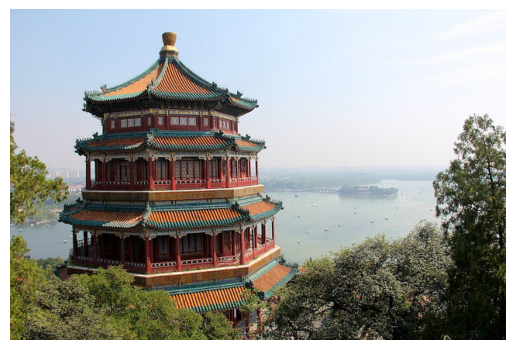

In [68]:
plt.imshow(images[0])
plt.axis("off")
plt.show()

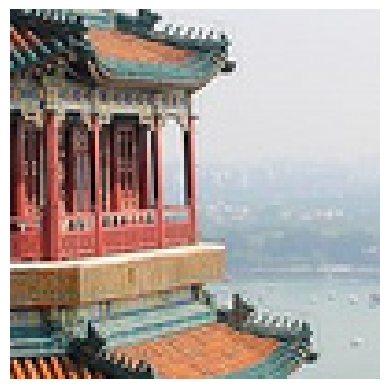

In [69]:
plt.imshow(cropped_images[0] / 255)
plt.axis("off")
plt.show()

# Using Pretrained Language Model Components

借助 TensorFlow Hub 庫(https://www.tensorflow.org/hub)，可以輕鬆地在自己的模型中重用文本、圖像、音頻等的pretrained model components。 這些模型組件稱為module。 只需瀏覽 TF Hub 存儲庫(https://tfhub.dev/)，找到需要的，然後將代碼複製到project中，該module就會自動下載並捆綁到 Keras 層，可以直接將其包含在模型中。 module通常包含預preprocessing code和pretrained weights，並且它們通常不需要額外的訓練（模型的其餘部分肯定需要訓練）。

可以使用一些強大的預訓練語言模型。 最強大的module相當大（幾 GB），

範例:

作為一個快速示例，使用 nnlm-en-dim50 module(版本 2)，這是一個相當基本的module，將原始文本作為輸入並輸出 50 維句子嵌入。 
導入 TensorFlow Hub 並使用它來加載module，然後使用該module將兩個句子編碼為向量：

In [70]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2")
sentence_embeddings = hub_layer(tf.constant(["To be", "Not to be"]))
sentence_embeddings.numpy().round(2)

array([[-0.25,  0.28,  0.01,  0.1 ,  0.14,  0.16,  0.25,  0.02,  0.07,
         0.13, -0.19,  0.06, -0.04, -0.07,  0.  , -0.08, -0.14, -0.16,
         0.02, -0.24,  0.16, -0.16, -0.03,  0.03, -0.14,  0.03, -0.09,
        -0.04, -0.14, -0.19,  0.07,  0.15,  0.18, -0.23, -0.07, -0.08,
         0.01, -0.01,  0.09,  0.14, -0.03,  0.03,  0.08,  0.1 , -0.01,
        -0.03, -0.07, -0.1 ,  0.05,  0.31],
       [-0.2 ,  0.2 , -0.08,  0.02,  0.19,  0.05,  0.22, -0.09,  0.02,
         0.19, -0.02, -0.14, -0.2 , -0.04,  0.01, -0.07, -0.22, -0.1 ,
         0.16, -0.44,  0.31, -0.1 ,  0.23,  0.15, -0.05,  0.15, -0.13,
        -0.04, -0.08, -0.16, -0.1 ,  0.13,  0.13, -0.18, -0.04,  0.03,
        -0.1 , -0.07,  0.07,  0.03, -0.08,  0.02,  0.05,  0.07, -0.14,
        -0.1 , -0.18, -0.13, -0.04,  0.15]], dtype=float32)

# The TensorFlow Datasets Project

The TensorFlow Datasets (TFDS) projec使加載常見數據集變得非常容易，從 MNIST 或 Fashion MNIST 等小型數據集到 ImageNet 等大型數據集（將需要相當多的磁盤空間！）。 包括圖像數據集、文本數據集（including translation datasets）、音頻和視頻數據集、時間序列等等。 可以訪問 https://homl.info/tfds 查看完整列表以及每個數據集的描述。 還可以查看now Your Data(https://knowyourdata.withgoogle.com/)，這是一個用於探索和理解 TFDS 提供的許多數據集的工具。

導入tensorflow_datasets，通常作為tfds，然後調用tfds.load()函數，該函數將下載想要的數據（除非之前已經下載過）並將數據作為數據集字典返回（通常一個用於訓練，一個用於測試 ，但這取決於選擇的數據集）。 例如，讓下載 MNIST：

In [71]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

c:\Users\Jonathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


然後，可以應用所需的任何轉換（通常是shuffling, batching, and prefetching），然後就可以訓練模型了。 這是一個簡單的例子：

In [ ]:
for batch in mnist_train.shuffle(10_000, seed=42).batch(32).prefetch(1):
    images = batch["image"]
    labels = batch["label"]
    # [...] do something with the images and labels

請注意，數據集中的每個項目都是包含特徵和標籤的字典。 但 Keras 希望每個item都是一個包含兩個元素（the features and the labels）的元組。 可以使用 map() 方法轉換數據集(But it’s simpler to ask the load() function to do this for you by setting as_supervised=True (obviously this works only for labeled datasets).)，如下所示：

In [ ]:
mnist_train = mnist_train.shuffle(10_000, seed=42).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)

In [ ]:
mnist_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
for line in mnist_train.take(2):
    print(line)

(<tf.Tensor: shape=(32, 28, 28, 1), dtype=uint8, numpy=
array([[[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]],


       [[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],


TFDS 提供了一種使用 split 參數來拆分數據的便捷方法。 例如，如果你使用前90%的訓練集進行訓練，剩下的10%進行驗證，整個測試集進行測試，那麼可以設置  split=["train[:90%]", "train[90%:]", "test"]。 load() 函數將返回所有三個數據集。 

這是一個完整的示例，使用 TFDS 加載和分割 MNIST 數據集，然後使用這些數據集來訓練和評估簡單的 Keras 模型：

In [ ]:
train_set, valid_set, test_set = tfds.load(
    name="mnist",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)
train_set = train_set.shuffle(10_000, seed=42).batch(32).prefetch(1)
valid_set = valid_set.batch(32).cache()
test_set = test_set.batch(32).cache()
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)
test_loss, test_accuracy = model.evaluate(test_set)

Epoch 1/5
1688/1688 [==============================] - 3s 1ms/step - loss: 9.5830 - accuracy: 0.8374 - val_loss: 6.0828 - val_accuracy: 0.8805
Epoch 2/5
1688/1688 [==============================] - 2s 1ms/step - loss: 5.7756 - accuracy: 0.8775 - val_loss: 5.9783 - val_accuracy: 0.8737
Epoch 3/5
1688/1688 [==============================] - 2s 987us/step - loss: 5.2644 - accuracy: 0.8841 - val_loss: 6.5668 - val_accuracy: 0.8730
Epoch 4/5
1688/1688 [==============================] - 2s 1ms/step - loss: 5.0787 - accuracy: 0.8866 - val_loss: 6.0718 - val_accuracy: 0.8820
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 5.5249 - accuracy: 0.8804
